<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-01-26 15:04:16--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-01-26 15:04:17 (148 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes (IGNORE THIS CELL IF SEABORN ALREADY INSTALLED!)
!conda install -c anaconda seaborn -y

failed

CondaError: KeyboardInterrupt



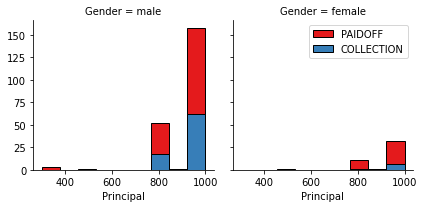

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

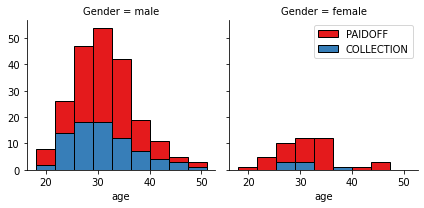

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


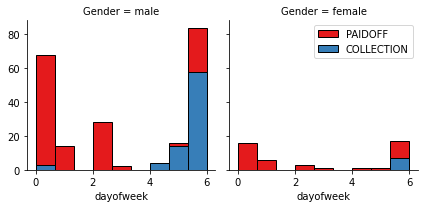

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
#Import Library train_test_split
from sklearn.model_selection import train_test_split

#Train/Test split - Ratio: 80 to 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [21]:
#Import Library KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#Train model to DataFrame
#Using for loops to find the best k for our model, ranging from k=1 to k=10
k = 11
mean_acc = np.zeros((k-1))
std_acc = np.zeros((k-1))

for n in range(1,k):
    #Train model and predict
    neighbor = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat = neighbor.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286, 0.67142857])

Text(0.5, 0, 'Number of Neighbors (k)')

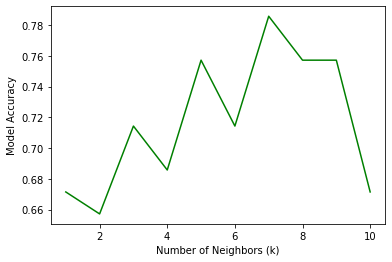

In [22]:
#Plot model accuracy to find the best k for KNN
plt.plot(range(1,k), mean_acc, 'g')
plt.ylabel('Model Accuracy')
plt.xlabel('Number of Neighbors (k)')

In [23]:
print('Based on the generated plot, the best k (number of neighbor) for our model would be k =', mean_acc.argmax()+1, '. With the accuracy of', mean_acc.max())

Based on the generated plot, the best k (number of neighbor) for our model would be k = 7 . With the accuracy of 0.7857142857142857


In [24]:
#Rebuild the model, using k = 7
best_k = 7
best_neighbor = KNeighborsClassifier(n_neighbors = best_k).fit(X_train, y_train) #KNN Model
best_yhat = best_neighbor.predict(X_test)
print('Train Set accuracy score:', metrics.accuracy_score(y_train, best_neighbor.predict(X_train)))
print('Test Set accuracy score:', metrics.accuracy_score(y_test, best_yhat))

Train Set accuracy score: 0.8079710144927537
Test Set accuracy score: 0.7857142857142857


**Now let's use Jaccard Index and F1 score.**

In [25]:
#Import Libraries for both Jaccard and F1
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

#Jaccard Index and F1 score
print('Jaccard Index:', metrics.jaccard_score(y_test, best_yhat, pos_label = 'PAIDOFF'))
print('F1 Score:', metrics.f1_score(y_test, best_yhat, average = 'weighted'))

Jaccard Index: 0.765625
F1 Score: 0.7766540244416351


# Decision Tree


Since our goal is to find which ML model is most suitable (has the best accuracy) to predict **loan_test.csv** data, we are going to use the same Train/Test split data that already generated in our previous ML model, which is the KNN model.

In [26]:
#Import Library DecisionTree
from sklearn.tree import DecisionTreeClassifier

#Create 2 instances of the Decision Tree model
DecisionTree_entropy = DecisionTreeClassifier(criterion = 'entropy')
DecisionTree_gini = DecisionTreeClassifier(criterion = 'gini')

There are 2 criterias in Decision Tree to measure the quality of a split, which are **entropy** and **gini**. I am going to build 2 Decision Tree model based on these 2 criterias and will compare which model has the best accuracy score.

In [27]:
#Train models to DataFrame
DecisionTree_entropy.fit(X_train, y_train)
DecisionTree_gini.fit(X_train, y_train) #Decision Tree Model

#Prediction
predDecisionTree_entropy = DecisionTree_entropy.predict(X_test)
predDecisionTree_gini = DecisionTree_gini.predict(X_test)

print("Models' predictions:")
print('entropy - ', predDecisionTree_entropy[0:5])
print('gini - ', predDecisionTree_gini[0:5])

print('\nDecision Tree (entropy) Accuracy:', metrics.accuracy_score(y_test, predDecisionTree_entropy))
print('Decision Tree (gini) Accuracy:', metrics.accuracy_score(y_test, predDecisionTree_gini))

Models' predictions:
entropy -  ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
gini -  ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']

Decision Tree (entropy) Accuracy: 0.7
Decision Tree (gini) Accuracy: 0.7


**Based on our findings, both entropy's and gini's approach have similar (very close to equal) value. We are going to use both approach to find Jaccard Index and F1 Score.**

In [28]:
#Jaccard Index and F1 Score
print('Jaccard Index - Entropy:', metrics.jaccard_score(y_test, predDecisionTree_entropy, pos_label = 'PAIDOFF'))
print('F1 Score - Entropy:', metrics.f1_score(y_test, predDecisionTree_entropy, average = 'weighted'))

print('\nJaccard Index - Gini:', metrics.jaccard_score(y_test, predDecisionTree_gini, pos_label = 'PAIDOFF'))
print('F1 Score - Gini:', metrics.f1_score(y_test, predDecisionTree_gini, average = 'weighted'))

Jaccard Index - Entropy: 0.6666666666666666
F1 Score - Entropy: 0.7142857142857144

Jaccard Index - Gini: 0.6612903225806451
F1 Score - Gini: 0.7181842036210967


# Support Vector Machine


In [29]:
#Import Library SVM
from sklearn import svm

#Create instances of the SVM model
SupVecMacRBF = svm.SVC(kernel='rbf')
SupVecMacPolyQuad = svm.SVC(kernel='poly', degree=2) #Quadratic
SupVecMacPolyCub = svm.SVC(kernel='poly', degree=3) #Cubic
SupVecMacLin = svm.SVC(kernel='linear')

In [30]:
#Train model
SupVecMacRBF.fit(X_train, y_train)
SupVecMacPolyQuad.fit(X_train, y_train)
SupVecMacPolyCub.fit(X_train, y_train)
SupVecMacLin.fit(X_train, y_train) #SVM Model

#Prediction
pred_RBF = SupVecMacRBF.predict(X_test)
pred_PolyQuad = SupVecMacPolyQuad.predict(X_test)
pred_PolyCub = SupVecMacPolyCub.predict(X_test)
pred_Lin = SupVecMacLin.predict(X_test)

#Accuracy score for each model
print('RBF Accuracy:', metrics.accuracy_score(y_test, pred_RBF))
print('Poly Quad Accuracy:', metrics.accuracy_score(y_test, pred_PolyQuad))
print('Poly Cub Accuracy:', metrics.accuracy_score(y_test, pred_PolyCub))
print('Linear Accuracy:', metrics.accuracy_score(y_test, pred_Lin))

RBF Accuracy: 0.7428571428571429
Poly Quad Accuracy: 0.7857142857142857
Poly Cub Accuracy: 0.7714285714285715
Linear Accuracy: 0.7857142857142857


**Based on our findings, both Polynomial with degree=2 and Linear has similar value. We will choose linear model to calculate Jaccard Index and F1 Score.**

In [31]:
#Jaccard Index and F1 Score
print('Jaccard Index - Linear:', metrics.jaccard_score(y_test, pred_Lin, pos_label='PAIDOFF'))
print('F1 Score - Linear:', metrics.f1_score(y_test, pred_Lin, average='weighted'))

Jaccard Index - Linear: 0.7857142857142857
F1 Score - Linear: 0.6914285714285714


# Logistic Regression


In [32]:
#Import Library
from sklearn.linear_model import LogisticRegression

#Create instance of the LogReg model
LogReg = LogisticRegression(C=0.01, solver='liblinear')

In [33]:
#Train model
LogReg.fit(X_train, y_train) #Logistic Regression Model

#Prediction
pred_LogReg = LogReg.predict(X_test)

#Accuracy
print('LogReg Accuracy:', metrics.accuracy_score(y_test, pred_LogReg))

LogReg Accuracy: 0.6857142857142857


Confusion Matrix, without normalization
[[46  9]
 [13  2]]


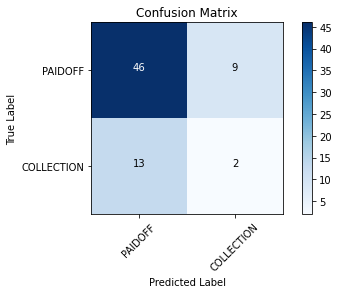

In [34]:
#Import Library Confusion Matrix
from sklearn.metrics import confusion_matrix


#Create Confusion Matrix plot function
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, without normalization")
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
#Plot non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_LogReg, labels=['PAIDOFF','COLLECTION'])

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'], normalize=False, title='Confusion Matrix')

In [35]:
#Import Library log_loss
from sklearn.metrics import log_loss

#Create instance for .predict_proba() function
pred_LogReg_prob = LogReg.predict_proba(X_test)

#Jaccard Index, F1 Score and LogLoss
print('Jaccard Index:', metrics.jaccard_score(y_test, pred_LogReg, pos_label='PAIDOFF'))
print('F1 Score:', metrics.f1_score(y_test, pred_LogReg, average='weighted'))
print('LogLoss:', log_loss(y_test, pred_LogReg_prob))

Jaccard Index: 0.6764705882352942
F1 Score: 0.6670522459996144
LogLoss: 0.5772287609479654


# Model Evaluation using Test set


First, download and load the test set:


In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-01-26 15:05:38--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-01-26 15:05:39 (54.7 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [37]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Data Pre-Processing for 'loan_test.csv' 

In [38]:
#Follow the same data pre-processing flow(procedure) with our current 'train_loan.csv' data
test_df['due_date'] = pd.to_datetime(test_df['due_date']) #Convert to date-time object
test_df['effective_date'] = pd.to_datetime(test_df['effective_date']) #Convert to date-time object
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek #Input new column
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0) #Input new column
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True) #convert value to 1 and 0

#One Hot Encoding
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [39]:
#Define test_X and test_y
test_X = test_Feature
test_y = test_df['loan_status'].values

#test_X data normalization
test_X = preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

**Our 'loan_test.csv' data is now ready to use.**

### Predict loan_test.csv data

In [40]:
#k-Nearest Neighbor
test_yhat_KNN = best_neighbor.predict(test_X)

#Decision Tree
test_yhat_DT = DecisionTree_gini.predict(test_X)

#Support Vector Machine
test_yhat_SVM = SupVecMacLin.predict(test_X)

#Logistic Regression
test_yhat_LR = LogReg.predict(test_X)
test_yhat_LR_prob = LogReg.predict_proba(test_X)

In [41]:
#KNN Jaccard Index and F1 Score
JS_KNN = metrics.jaccard_score(test_y, test_yhat_KNN, pos_label='PAIDOFF')
FS_KNN = metrics.f1_score(test_y, test_yhat_KNN, average='weighted')
print('Jaccard Index - KNN:', JS_KNN)
print('F1 Score - KNN:', FS_KNN)

#Decision Tree Jaccard Index and F1 Score
JS_DT = metrics.jaccard_score(test_y, test_yhat_DT, pos_label='PAIDOFF')
FS_DT = metrics.f1_score(test_y, test_yhat_DT, average='weighted')
print('\nJaccard Index - Decision Tree:', JS_DT)
print('F1 Score - Decision Tree:', FS_DT)

#Support Vector Machine Jaccard Index and F1 Score
JS_SVM = metrics.jaccard_score(test_y, test_yhat_SVM, pos_label='PAIDOFF')
FS_SVM = metrics.f1_score(test_y, test_yhat_SVM, average='weighted')
print('\nJaccard Index - SVM:', JS_SVM)
print('F1 Score - SVM:', FS_SVM)

#Logistic Regression Jaccard Index, F1 Score and LogLoss
JS_LR = metrics.jaccard_score(test_y, test_yhat_LR, pos_label='PAIDOFF')
FS_LR = metrics.f1_score(test_y, test_yhat_LR, average='weighted')
LL_LR = log_loss(test_y, test_yhat_LR_prob)
print('\nJaccard Index - LogReg:', JS_LR)
print('F1 Score - LogReg:', FS_LR)
print('LogLoss - LogReg:', LL_LR)


Jaccard Index - KNN: 0.6538461538461539
F1 Score - KNN: 0.6328400281888654

Jaccard Index - Decision Tree: 0.6382978723404256
F1 Score - Decision Tree: 0.6942854039628232

Jaccard Index - SVM: 0.7407407407407407
F1 Score - SVM: 0.6304176516942475

Jaccard Index - LogReg: 0.7358490566037735
F1 Score - LogReg: 0.6604267310789049
LogLoss - LogReg: 0.5672153379912981


In [42]:
Report = pd.DataFrame(columns=['Algorithm','Jaccard','F1-score','LogLoss'], index=range(4))

Report['Algorithm'] = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
Report['Jaccard'] = ["{:.2f}".format(JS_KNN), "{:.2f}".format(JS_DT), "{:.2f}".format(JS_SVM), "{:.2f}".format(JS_LR)]
Report['F1-score'] = ["{:.2f}".format(FS_KNN), "{:.2f}".format(FS_DT), "{:.2f}".format(FS_SVM), "{:.2f}".format(FS_LR)]
Report['LogLoss'] = ['NA', 'NA', 'NA', "{:.2f}".format(JS_LR)]
Report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.65,0.63,NA
1,Decision Tree,0.64,0.69,NA
2,SVM,0.74,0.63,NA
3,Logistic Regression,0.74,0.66,0.74


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
